In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os, json, numpy as np, pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

import xgboost as xgb
from xgboost import XGBRegressor

# Class order must match how you trained the CNN heads:
COLOR_CLASSES   = ["black","blue","brown","green","grey","multi","orange","pink","red","white"]
PRODUCT_CLASSES = ["dress","shirt","tshirt","jeans","trousers","shorts","skirt","saree","kurta","jacket"]

# CSV and CNN model paths (edit if yours are in different folders)
CSV_PATH       = "/content/drive/MyDrive/cleaned_data/merged.csv"
CNN_MODEL_PATH = "/content/drive/MyDrive/cleaned_data/best_model.h5"

# Image directory
#!mkdir /content/sample_images
#!find "/content/drive/MyDrive/cleaned_data/images" -type f | head -n 5000 | while read f; do cp "$f" /content/sample_images/; done
IMAGE_DIR = "/content/sample_images"

# Output/model helper files (keep in /content)
XGB_MODEL_PATH    = "/content/xgb_price.json"
FEATURE_ORDER_CSV = "/content/xgb_feature_order.csv"
TAGS_CACHE_PARQUET = "/content/tags_cache.parquet"
CLASS_META_PATH   = "/content/class_meta.json"
TAG_PRIORS_JSON   = "/content/tag_priors.json"
ONEHOT_MAPS_JSON  = "/content/onehot_maps.json"

cnn = keras.models.load_model(CNN_MODEL_PATH, compile=False)
# Save class meta
json.dump({"color": COLOR_CLASSES, "product": PRODUCT_CLASSES}, open(CLASS_META_PATH, "w"))

# Data load
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["article_id","price"]).reset_index(drop=True)
print("Rows:", len(df))

# Image resolver
# --- Robust image resolver for zero-padded filenames ---
import os, glob, re

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

def list_all_images(root):
    files = []
    for ext in IMAGE_EXTS:
        files.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
    return files

def first_10digit_token(name):
    # Find first 10-digit number in filename
    m = re.search(r"(\d{10})", name)
    return m.group(1) if m else None

# Build the index: "0108775015" → full path
ALL_IMAGES = list_all_images(IMAGE_DIR)
IMAGE_INDEX = {}
for p in ALL_IMAGES:
    key = first_10digit_token(os.path.basename(p))
    if key and key not in IMAGE_INDEX:
        IMAGE_INDEX[key] = p

print(f"Indexed {len(ALL_IMAGES)} image files | usable 10-digit keys: {len(IMAGE_INDEX)}")

def find_image_path(article_id):
    # Match CSV ids like 108775015 → zero-pad → "0108775015"
    aid_key = str(article_id).split(".")[0].zfill(10)
    return IMAGE_INDEX.get(aid_key, None)

Rows: 104547
Indexed 6962 image files | usable 10-digit keys: 6962


In [19]:
aid_keys = set(df["article_id"].astype(str).str.split(".").str[0].str.zfill(10))
hits = sum(k in IMAGE_INDEX for k in aid_keys)
print(f"CSV unique article_ids: {len(aid_keys)} | with images found: {hits}")

# Print 5 sample matches
for k in list(aid_keys)[:5]:
    if k in IMAGE_INDEX:
        print(k, "->", os.path.basename(IMAGE_INDEX[k]))

CSV unique article_ids: 104547 | with images found: 6952
0494327005 -> 0494327005.jpg


In [20]:

# Load safely (no training state needed)
cnn = tf.keras.models.load_model(CNN_MODEL_PATH, compile=False)
print("CNN output heads:", list(cnn.output_names))  # expect ['color_output','product_output'] or similar

IMG_SIZE = (224, 224)
TOPK = 3

def _prep(img_path):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32)
    return np.expand_dims(preprocess_input(arr), axis=0)

def _get_head(out_dict, base):
    # Works for 'color' or 'color_output', etc.
    return out_dict.get(base) or out_dict.get(f"{base}_output")

def predict_tags(img_path, model=cnn):
    x = _prep(img_path)
    raw = model.predict(x, verbose=0)
    out = dict(zip(model.output_names, raw))

    color_prob   = _get_head(out, "color")[0]
    product_prob = _get_head(out, "product")[0]

    color_topk   = np.argsort(color_prob)[-TOPK:][::-1]
    product_topk = np.argsort(product_prob)[-TOPK:][::-1]

    return {
        "color_prob":   color_prob.astype(float),
        "product_prob": product_prob.astype(float),
        "color_topk":   color_topk.tolist(),
        "product_topk": product_topk.tolist(),
    }

# smoke test on first row with an image
for _, r in df.iterrows():
    p = find_image_path(r["article_id"])
    if p:
        print("Sample image:", p)
        print(predict_tags(p))
        break

CNN output heads: ['color_output', 'product_output']
Sample image: /content/sample_images/0455504002.jpg
{'color_prob': array([0.13386284, 0.04449925, 0.04700278, 0.02292158, 0.05389858,
       0.02736464, 0.03636428, 0.21535204, 0.37999958, 0.00482635]), 'product_prob': array([0.0125805 , 0.01954319, 0.02100842, 0.06261291, 0.01200981,
       0.02259027, 0.04429784, 0.09890328, 0.64465392, 0.74302071]), 'color_topk': [8, 7, 0], 'product_topk': [9, 8, 7]}


In [21]:
# ---- Build & load tags cache (runs once) ----
import os, glob, numpy as np, pandas as pd

def load_tag_cache():
    if os.path.exists(TAGS_CACHE_PARQUET):
        return pd.read_parquet(TAGS_CACHE_PARQUET)
    raise FileNotFoundError("Run build_tags_cache(...) first.")

def build_tags_cache(df_articles_like):
    rows = []
    for _, r in df_articles_like.iterrows():
        aid = int(r["article_id"])
        ip = find_image_path(aid)
        if not ip:
            continue
        t = predict_tags(ip)
        rec = {"article_id": aid}
        for i, c in enumerate(COLOR_CLASSES):
            rec[f"prob_color_{c}"] = float(t["color_prob"][i])
        for j, p in enumerate(PRODUCT_CLASSES):
            rec[f"prob_product_{p}"] = float(t["product_prob"][j])
        rec["top1_color"]   = COLOR_CLASSES[t["color_topk"][0]]
        rec["top1_product"] = PRODUCT_CLASSES[t["product_topk"][0]]
        rows.append(rec)
    tag_cache = pd.DataFrame(rows).drop_duplicates("article_id")
    tag_cache.to_parquet(TAGS_CACHE_PARQUET, index=False)
    print("Saved tag cache:", TAGS_CACHE_PARQUET, "| rows:", len(tag_cache))

# Build ONCE (use all unique article_ids you care about)
unique_articles = df[["article_id"]].drop_duplicates()
build_tags_cache(unique_articles)

Saved tag cache: /content/tags_cache.parquet | rows: 6952


In [23]:
CATEGORICAL_KEEP = [
    "colour_group_name",
    "perceived_colour_value_name",
    "perceived_colour_master_name",
    "product_type_name",
    "graphical_appearance_name",
]

def fit_small_onehot(df, topN=15):
    maps = {}
    for col in CATEGORICAL_KEEP:
        vc = df[col].fillna("Unknown").value_counts()
        maps[col] = vc.head(topN).index.tolist()
    return maps

def transform_small_onehot(row, maps):
    feats = {}
    for col in CATEGORICAL_KEEP:
        val = str(row.get(col, "Unknown")) if pd.notna(row.get(col)) else "Unknown"
        keep = maps[col]
        hit = val if val in keep else "Other"
        for k in keep + ["Other"]:
            feats[f"{col}__{k}"] = 1.0 if k == hit else 0.0
    return feats

def save_onehot_maps(maps, path=ONEHOT_MAPS_JSON):
    json.dump(maps, open(path, "w"))

def load_onehot_maps(path=ONEHOT_MAPS_JSON):
    return json.load(open(path))

In [24]:
def compute_tag_priors_from_cache(df_train):
    cache = load_tag_cache()
    t = df_train.merge(cache, on="article_id", how="inner")
    color_mean   = t.groupby("top1_color")["price"].mean().to_dict()
    product_mean = t.groupby("top1_product")["price"].mean().to_dict()
    color_mean   = {c: float(color_mean.get(c, 0.0)) for c in COLOR_CLASSES}
    product_mean = {p: float(product_mean.get(p, 0.0)) for p in PRODUCT_CLASSES}
    return {"color_mean": color_mean, "product_mean": product_mean}

def tag_features_from_probs(tag_dict, tag_priors=None):
    feats = {}
    # probs
    for i, c in enumerate(COLOR_CLASSES):
        feats[f"prob_color_{c}"] = float(tag_dict["color_prob"][i])
    for j, p in enumerate(PRODUCT_CLASSES):
        feats[f"prob_product_{p}"] = float(tag_dict["product_prob"][j])
    # top-K one-hot
    for i, c in enumerate(COLOR_CLASSES):
        feats[f"topk_color_{c}"] = 1.0 if i in tag_dict["color_topk"] else 0.0
    for j, p in enumerate(PRODUCT_CLASSES):
        feats[f"topk_product_{p}"] = 1.0 if j in tag_dict["product_topk"] else 0.0
    # priors
    if tag_priors:
        cmean = tag_priors.get("color_mean", {})
        pmean = tag_priors.get("product_mean", {})
        feats["prior_color_weighted"] = sum(feats[f"prob_color_{c}"] * cmean.get(c, 0.0) for c in COLOR_CLASSES)
        feats["prior_product_weighted"] = sum(feats[f"prob_product_{p}"] * pmean.get(p, 0.0) for p in PRODUCT_CLASSES)
        top1c = COLOR_CLASSES[tag_dict["color_topk"][0]]
        top1p = PRODUCT_CLASSES[tag_dict["product_topk"][0]]
        feats["prior_color_top1"] = cmean.get(top1c, 0.0)
        feats["prior_product_top1"] = pmean.get(top1p, 0.0)
    return feats

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def tag_features_from_cache_row(row, priors):
    feats = {}
    for c in COLOR_CLASSES:
        feats[f"prob_color_{c}"]   = float(row.get(f"prob_color_{c}", 0.0))
    for p in PRODUCT_CLASSES:
        feats[f"prob_product_{p}"] = float(row.get(f"prob_product_{p}", 0.0))

    cmean = priors.get("color_mean", {})
    pmean = priors.get("product_mean", {})
    feats["prior_color_weighted"]   = sum(feats[f"prob_color_{c}"]   * cmean.get(c, 0.0) for c in COLOR_CLASSES)
    feats["prior_product_weighted"] = sum(feats[f"prob_product_{p}"] * pmean.get(p, 0.0) for p in PRODUCT_CLASSES)

    top1c = row.get("top1_color", None)
    top1p = row.get("top1_product", None)
    feats["prior_color_top1"]   = cmean.get(top1c, 0.0) if top1c else 0.0
    feats["prior_product_top1"] = pmean.get(top1p, 0.0) if top1p else 0.0
    return feats

def build_matrix_from_cache(dframe, maps, priors):
    try:
        cache = load_tag_cache().set_index("article_id")
    except FileNotFoundError:
        raise RuntimeError("Run build_tags_cache(df) first — CNN tags missing.")

    rows, y = [], []
    for _, r in dframe.iterrows():
        aid = int(r["article_id"])
        if aid not in cache.index:
            continue
        tagrow = cache.loc[aid]
        feats = {}
        feats.update(tag_features_from_cache_row(tagrow, priors))
        feats.update(transform_small_onehot(r, maps))
        rows.append(feats)
        y.append(float(r["price"]))
    X = pd.DataFrame(rows).fillna(0.0)
    y = np.array(y, dtype=float)
    return X, y

onehot_maps = fit_small_onehot(train_df, topN=15)
save_onehot_maps(onehot_maps)

tag_priors = compute_tag_priors_from_cache(train_df)
json.dump(tag_priors, open(TAG_PRIORS_JSON, "w"))

X_train, y_train = build_matrix_from_cache(train_df, onehot_maps, tag_priors)
X_val,   y_val   = build_matrix_from_cache(val_df,   onehot_maps, tag_priors)
y_train_scaled = y_train * 100
y_val_scaled = y_val * 100
# Save feature order
pd.Series(X_train.columns).to_csv(FEATURE_ORDER_CSV, index=False, header=False)

# Train XGBoost (no Linear/RandomForest)
#xgb_reg = XGBRegressor(
    #n_estimators=700,
    #learning_rate=0.08,
    #max_depth=6,
    #subsample=0.9,
    #colsample_bytree=0.7,
    #reg_alpha=1.0,
    #reg_lambda=2.0,
    #random_state=42,
    #tree_method="hist",
    #objective="reg:squarederror",
#)
xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_reg.fit(X_train, y_train_scaled, eval_set=[(X_val, y_val_scaled)], verbose=False)

pred_val_scaled = xgb_reg.predict(X_val)
pred_val = pred_val_scaled / 100  # bring predictions back to original scale

print("R²:", r2_score(y_val, pred_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, pred_val)))
xgb_reg.save_model(XGB_MODEL_PATH)
print("Saved:", XGB_MODEL_PATH)

R²: 0.239653006795303
RMSE: 0.013561519381659101
Saved: /content/xgb_price.json


In [26]:
print("Train samples:", len(X_train), "| Val samples:", len(X_val))
print("Price mean:", y_train.mean(), "| std:", y_train.std())
print("Price range:", y_train.min(), "to", y_train.max())

Train samples: 5551 | Val samples: 1401
Price mean: 0.01668776735906489 | std: 0.014336735033815672
Price range: 0.000322033898305 to 0.1677966101694915


In [27]:
feature_order = pd.read_csv(FEATURE_ORDER_CSV, header=None)[0].tolist()
tag_priors    = json.load(open(TAG_PRIORS_JSON))
onehot_maps   = load_onehot_maps(ONEHOT_MAPS_JSON)

def row_to_X_from_cache(row):
    cache = load_tag_cache().set_index("article_id")
    aid = int(row["article_id"])
    if aid not in cache.index:
        raise FileNotFoundError(f"No tags for article_id={aid} in tags_cache")
    tagrow = cache.loc[aid]
    feats = {}
    feats.update(tag_features_from_cache_row(tagrow, tag_priors))
    feats.update(transform_small_onehot(row, onehot_maps))
    X = pd.DataFrame([feats]).reindex(columns=feature_order).fillna(0.0)
    return X, tagrow

def predict_price_for_row_no_image(row):
    X, tagrow = row_to_X_from_cache(row)
    price = float(xgb_reg.predict(X)[0])
    top_colors   = [(tagrow["top1_color"],   tag_priors["color_mean"].get(tagrow["top1_color"], 0.0))]
    top_products = [(tagrow["top1_product"], tag_priors["product_mean"].get(tagrow["top1_product"], 0.0))]
    return {"predicted_price": price, "top_colors": top_colors, "top_products": top_products}

In [28]:
tested = 0
for _, row in df.sample(min(5, len(df)), random_state=7).iterrows():
    if not find_image_path(row["article_id"]):
        continue
    print(predict_price_for_row_no_image(row))
    tested += 1
    if tested == 3: break

In [29]:
print("train_df rows:", len(train_df), "val_df rows:", len(val_df))

def has_img(aid):
    return find_image_path(aid) is not None

hits_train = sum(has_img(a) for a in train_df["article_id"])
hits_val   = sum(has_img(a) for a in val_df["article_id"])
print(f"Images found — train: {hits_train}/{len(train_df)}, val: {hits_val}/{len(val_df)}")

train_df rows: 83637 val_df rows: 20910
Images found — train: 5551/83637, val: 1401/20910


In [30]:
!mkdir -p /content/drive/MyDrive/cleaned_data/sample_zips
!zip -rq /content/drive/MyDrive/cleaned_data/sample_zips/sample_images.zip /content/sample_images
!ls -lh /content/drive/MyDrive/cleaned_data/sample_zips/

total 2.2G
-rw------- 1 root root 2.2G Nov 10 09:58 sample_images.zip


In [35]:
# ==========================================
# FIXED: robust head-detection + softmax + class meta
# (drop-in: redefines predict_from_image)
# ==========================================
import os, re, json, numpy as np, pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
import xgboost as xgb

# ------- Load class order from meta if available (MUST match training) -------
CLASS_META_PATHS = [
    "/content/class_meta.json",
    "/content/drive/MyDrive/cleaned_data/class_meta.json",
]
COLOR_CLASSES   = ["black","blue","brown","green","grey","multi","orange","pink","red","white"]
PRODUCT_CLASSES = ["dress","shirt","tshirt","jeans","trousers","shorts","skirt","saree","kurta","jacket"]
for pth in CLASS_META_PATHS:
    if os.path.exists(pth):
        meta = json.load(open(pth))
        COLOR_CLASSES   = meta.get("color", COLOR_CLASSES)
        PRODUCT_CLASSES = meta.get("product", PRODUCT_CLASSES)
        break

# ------- File locations (same as earlier) -------
CSV_PATH       = "/content/drive/MyDrive/cleaned_data/merged.csv"
CNN_MODEL_PATH = "/content/drive/MyDrive/cleaned_data/best_model.h5"
DRIVE_CACHE_DIR  = "/content/drive/MyDrive/cleaned_data/cache"
XGB_MODEL_PATH    = "/content/xgb_price.json" if os.path.exists("/content/xgb_price.json") else os.path.join(DRIVE_CACHE_DIR, "xgb_price.json")
FEATURE_ORDER_CSV = "/content/xgb_feature_order.csv" if os.path.exists("/content/xgb_feature_order.csv") else os.path.join(DRIVE_CACHE_DIR, "xgb_feature_order.csv")
TAG_PRIORS_JSON   = "/content/tag_priors.json"       if os.path.exists("/content/tag_priors.json")       else os.path.join(DRIVE_CACHE_DIR, "tag_priors.json")
ONEHOT_MAPS_JSON  = "/content/onehot_maps.json"      if os.path.exists("/content/onehot_maps.json")      else os.path.join(DRIVE_CACHE_DIR, "onehot_maps.json")

# ------- Load base data & metadata -------
df = pd.read_csv(CSV_PATH).dropna(subset=["article_id","price"]).reset_index(drop=True)
feature_order = pd.read_csv(FEATURE_ORDER_CSV, header=None)[0].tolist()
tag_priors    = json.load(open(TAG_PRIORS_JSON))
onehot_maps   = json.load(open(ONEHOT_MAPS_JSON))

# ------- Models -------
try:
    cnn
except NameError:
    cnn = tf.keras.models.load_model(CNN_MODEL_PATH, compile=False)

booster = xgb.Booster()
booster.load_model(XGB_MODEL_PATH)

# ------- Helpers -------
IMG_SIZE = (224, 224)
TOPK = 3
SCALE = 100.0
CATEGORICAL_KEEP = [
    "colour_group_name","perceived_colour_value_name","perceived_colour_master_name",
    "product_type_name","graphical_appearance_name",
]

def _softmax(a, axis=-1):
    a = np.asarray(a, dtype=np.float32)
    a = a - np.max(a, axis=axis, keepdims=True)
    e = np.exp(a)
    return e / np.sum(e, axis=axis, keepdims=True)

def _prep(img_path):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32)
    return np.expand_dims(preprocess_input(arr), axis=0)

def _detect_heads(raw_outputs, output_names):
    """
    Map model outputs to (color, product) robustly:
    1) If names exist, use them.
    2) Otherwise, use vector lengths to match expected class counts.
    """
    # Case A: names are present and unique
    if output_names and len(output_names) == len(raw_outputs):
        named = dict(zip(output_names, raw_outputs))
        color = named.get("color") or named.get("color_output")
        product = named.get("product") or named.get("product_output")
        if color is not None and product is not None:
            return color, product

    # Case B: fallback by shape matching
    outs = list(raw_outputs)
    by_len = {o.shape[-1]: o for o in outs}
    color = by_len.get(len(COLOR_CLASSES))
    product = by_len.get(len(PRODUCT_CLASSES))

    # If still ambiguous (same lengths), just pick consistently
    if color is None or product is None:
        # Sort by length descending; assume the *other* is product
        outs_sorted = sorted(outs, key=lambda x: x.shape[-1], reverse=True)
        # Try both assignments
        a, b = outs_sorted[0], outs_sorted[1]
        if a.shape[-1] == len(PRODUCT_CLASSES) and b.shape[-1] == len(COLOR_CLASSES):
            product, color = a, b
        else:
            color, product = b, a
    return color, product

def predict_tags_from_image(img_path, model=cnn):
    x = _prep(img_path)
    raw = model.predict(x, verbose=0)
    if not isinstance(raw, (list, tuple)):
        raw = [raw]
    color_raw, product_raw = _detect_heads(raw, getattr(model, "output_names", []))

    color_prob   = color_raw[0]
    product_prob = product_raw[0]

    # Ensure proper probability vectors
    if not np.isclose(np.sum(color_prob), 1.0, atol=1e-3):
        color_prob = _softmax(color_prob)
    if not np.isclose(np.sum(product_prob), 1.0, atol=1e-3):
        product_prob = _softmax(product_prob)

    color_topk   = np.argsort(color_prob)[-TOPK:][::-1]
    product_topk = np.argsort(product_prob)[-TOPK:][::-1]

    return {
        "color_prob":   color_prob.astype(float),
        "product_prob": product_prob.astype(float),
        "color_topk":   color_topk.tolist(),
        "product_topk": product_topk.tolist(),
    }

def transform_small_onehot(row_like, maps):
    feats = {}
    for col in CATEGORICAL_KEEP:
        val = str(row_like.get(col, "Unknown"))
        keep = maps[col]
        hit = val if val in keep else "Other"
        for k in keep + ["Other"]:
            feats[f"{col}__{k}"] = 1.0 if k == hit else 0.0
    return feats

def tag_features_from_probs(tag_dict, tag_priors):
    feats = {}
    for i, c in enumerate(COLOR_CLASSES):
        feats[f"prob_color_{c}"] = float(tag_dict["color_prob"][i])
    for j, p in enumerate(PRODUCT_CLASSES):
        feats[f"prob_product_{p}"] = float(tag_dict["product_prob"][j])
    for i, c in enumerate(COLOR_CLASSES):
        feats[f"topk_color_{c}"] = 1.0 if i in tag_dict["color_topk"] else 0.0
    for j, p in enumerate(PRODUCT_CLASSES):
        feats[f"topk_product_{p}"] = 1.0 if j in tag_dict["product_topk"] else 0.0
    cmean = tag_priors.get("color_mean", {})
    pmean = tag_priors.get("product_mean", {})
    feats["prior_color_weighted"]   = sum(feats[f"prob_color_{c}"]   * cmean.get(c, 0.0) for c in COLOR_CLASSES)
    feats["prior_product_weighted"] = sum(feats[f"prob_product_{p}"] * pmean.get(p, 0.0) for p in PRODUCT_CLASSES)
    top1c = COLOR_CLASSES[tag_dict["color_topk"][0]]
    top1p = PRODUCT_CLASSES[tag_dict["product_topk"][0]]
    feats["prior_color_top1"]   = cmean.get(top1c, 0.0)
    feats["prior_product_top1"] = pmean.get(top1p, 0.0)
    return feats

def infer_article_id_from_name(path):
    m = re.search(r"(\d{10})", os.path.basename(path))
    return int(m.group(1)) if m else None

def pick_row_for_article(aid_int):
    if aid_int is None:
        return None
    hit = df.loc[df["article_id"].astype(str).str.split(".").str[0].astype(int) == int(aid_int)]
    return hit.iloc[0].to_dict() if len(hit) else None

def make_unknown_row():
    return {col: "Unknown" for col in CATEGORICAL_KEEP}

def _predict_with_booster(X_df):
    dm = xgb.DMatrix(X_df.values.astype(np.float32), feature_names=list(X_df.columns))
    return booster.predict(dm)

def build_X_from_image(img_path, explicit_article_id=None):
    tag_dict = predict_tags_from_image(img_path)
    aid = explicit_article_id if explicit_article_id is not None else infer_article_id_from_name(img_path)
    row = pick_row_for_article(aid) or make_unknown_row()
    feats = {}
    feats.update(tag_features_from_probs(tag_dict, tag_priors))
    feats.update(transform_small_onehot(row, onehot_maps))
    X = pd.DataFrame([feats]).reindex(columns=feature_order).fillna(0.0)
    color_top = [(COLOR_CLASSES[i], float(tag_dict["color_prob"][i])) for i in tag_dict["color_topk"]]
    prod_top  = [(PRODUCT_CLASSES[i], float(tag_dict["product_prob"][i])) for i in tag_dict["product_topk"]]
    return X, color_top, prod_top

def predict_from_image(img_path, article_id=None):
    X, color_top, prod_top = build_X_from_image(img_path, explicit_article_id=article_id)
    price_scaled = float(_predict_with_booster(X)[0])
    price = price_scaled / SCALE
    return {
        "image": img_path,
        "predicted_price": round(price, 2),
        "top_colors": [{"label": c, "prob": round(p, 4)} for c, p in color_top],
        "top_products": [{"label": p, "prob": round(q, 4)} for p, q in prod_top],
    }

print("✔️ Fixed. Re-run your upload cell now.")


✔️ Fixed. Re-run your upload cell now.


👇 Click 'Choose Files' to upload an image:


Saving 0920356002.jpg to 0920356002 (1).jpg
Enter article_id (or press Enter to skip): 0920356002


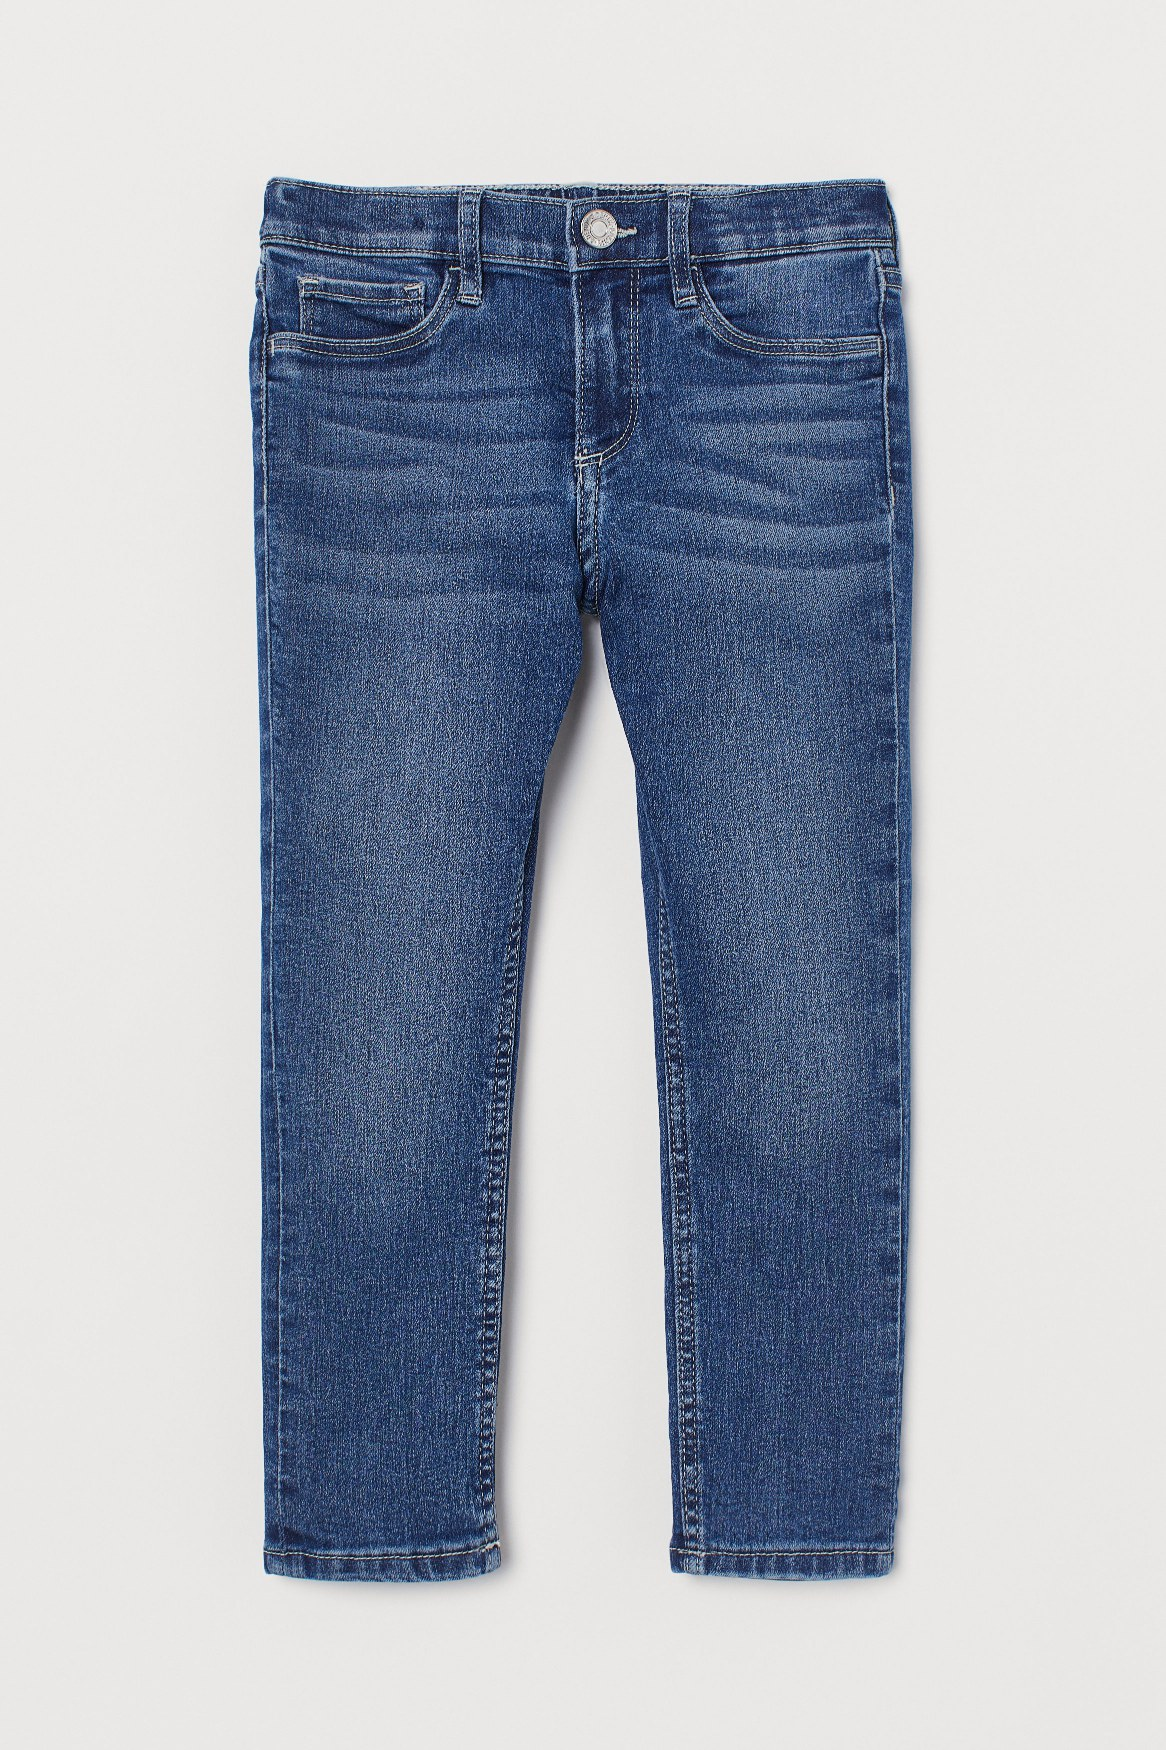


✅ Prediction Result:
📸 Image: 0920356002 (1).jpg
💰 Predicted Price: ₹0.03

🎨 Top Colors:
  - Pink (15.2%)
  - Red (12.4%)
  - Black (10.0%)

👕 Top Products:
  - Kurta (21.5%)
  - Jacket (12.4%)
  - Jeans (9.3%)


In [38]:
# ==========================================
# 📸 LIVE IMAGE UPLOAD → COLOR + PRODUCT + PRICE
# ==========================================
from google.colab import files
import os, re
from IPython.display import Image as IPyImage, display

# Helper: try to extract 10-digit article_id from filename
def _infer_article_id_from_name(name):
    m = re.search(r"(\d{10})", name)
    return int(m.group(1)) if m else None

print("👇 Click 'Choose Files' to upload an image:")
uploaded = files.upload()  # shows upload button

if uploaded:
    # Take first uploaded file
    name, _ = next(iter(uploaded.items()))
    local_path = f"/content/{name}"

    # Ask user for article_id (optional)
    try:
        user_article_id = input("Enter article_id (or press Enter to skip): ").strip()
        user_article_id = int(user_article_id) if user_article_id else None
    except:
        user_article_id = None

    # If not given, infer from filename
    if user_article_id is None:
        user_article_id = _infer_article_id_from_name(name)

    # --- Run prediction (this uses your existing function) ---
    result = predict_from_image(local_path, article_id=user_article_id)

    # --- Show the uploaded image preview ---
    display(IPyImage(filename=local_path, width=250))

    # --- Nicely formatted printout ---
    print("\n✅ Prediction Result:")
    print(f"📸 Image: {os.path.basename(result['image'])}")
    print(f"💰 Predicted Price: ₹{result['predicted_price']:.2f}")

    print("\n🎨 Top Colors:")
    for c in result["top_colors"]:
        print(f"  - {c['label'].title()} ({c['prob']*100:.1f}%)")

    print("\n👕 Top Products:")
    for p in result["top_products"]:
        print(f"  - {p['label'].title()} ({p['prob']*100:.1f}%)")

else:
    print("No image uploaded.")